In [1]:
# in progress...

In [2]:
from climada.hazard import Centroids
import pandas as pd
import numpy as np
import scipy as sp
import datetime
from climada.hazard import Hazard
import xarray as xr
from climada.util.api_client import Client

# let's get river floods from the CLIMADA API for Japan

In [3]:
client = Client()
river_flood = client.get_hazard('river_flood', properties={'country_iso3alpha':'JPN', 'climate_scenario': 'rcp85', 'year_range':'2010_2030'})

2024-04-30 17:19:30,206 - climada.hazard.base - INFO - Reading /Users/szelie/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_JPN_2010_2030/v3/river_flood_150arcsec_rcp85_JPN_2010_2030.hdf5


# We then generate a heatstress hazard based on the "hurs", "tas" and "rsds" data for ISIMIP2b https://data.isimip.org/download/

In [4]:
#need to download hurs, tas and rsds data
from pathlib import Path
DATA_DIR = Path("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/ISIMIP2b")

In [5]:
# Initialize a dictionary to store heatwave data
heatwave_data_dict = {}

# Process data for each warming level
heat_hazards ={}

def calculate_wbgt(Ta, RH, SR):
    # ESI formula for WBGT
    ESI = (0.63 * Ta - 0.03 * RH + 0.002 * SR +
           0.0054 * (Ta * RH) - 0.073 * (0.1 + SR) ** -1)
    ESI = ESI.where(ESI >= 20, 0)  # Apply threshold
    return ESI



In [6]:
hurs_data_list = []
tas_data_list = []
rsds_data_list = []
scenario = 'rcp85'
model = 'gfdl-esm2m'
cnt = 'jpn'

for year in [2011,2021]:
    hurs_data_list.append(xr.open_dataset(DATA_DIR / f"hurs_day_GFDL-ESM2M_rcp85_r1i1p1_EWEMBI_{str(year)}0101-{str(year+9)}1231_{cnt}.nc4"))
    tas_data_list.append(xr.open_dataset(DATA_DIR / f"tas_day_GFDL-ESM2M_rcp85_r1i1p1_EWEMBI_{str(year)}0101-{str(year+9)}1231_{cnt}.nc4"))
    rsds_data_list.append(xr.open_dataset(DATA_DIR / f"rsds_day_GFDL-ESM2M_rcp85_r1i1p1_EWEMBI_{str(year)}0101-{str(year+9)}1231_{cnt}.nc4"))


#print(years)
tas_data_relevant_years = xr.concat(tas_data_list, dim='time')
#tas_data_relevant_years = tas_data.sel(time=slice("-".join([str(years[0]),"01","01"]), "-".join([str(years[1]-1),"12","31"])))

hurs_data_relevant_years = xr.concat(hurs_data_list, dim='time')
#hurs_data_relevant_years = hurs_data.sel(time=slice("-".join([str(years[0]),"01","01"]), "-".join([str(years[1]-1),"12","31"])))

rsds_data_relevant_years = xr.concat(rsds_data_list, dim='time')
#rsds_data_relevant_years = rsds_data.sel(time=slice("-".join([str(years[0]),"01","01"]), "-".join([str(years[1]-1),"12","31"])))



Ta = tas_data_relevant_years.tas - 273.15  # Convert to Celsius
RH = hurs_data_relevant_years.hurs  # It is assumed that it's already in percentage
SR = rsds_data_relevant_years.rsds

wbgt = calculate_wbgt(Ta, RH, SR)
wbgt_monthly_max = wbgt.resample(time='1M').max()

n_times, n_latitude, n_longitude = wbgt_monthly_max.shape
wbgt_reshaped = wbgt_monthly_max.data.reshape(n_times, n_latitude * n_longitude)
#wbgt_reshaped[wbgt_reshaped<25] = 0
wbgt_reshaped = sp.sparse.csr_matrix(wbgt_reshaped)
df = wbgt_monthly_max.to_dataframe('').groupby(['lat','lon']).sum().reset_index()
centroids = Centroids.from_lat_lon(-df.lat,df.lon)

time = wbgt_monthly_max.time
ordinal_dates = pd.to_datetime(time.values).to_pydatetime()
ordinal_dates = [date.toordinal() for date in ordinal_dates]
years = [datetime.date.fromordinal(date).year for date in ordinal_dates]
event_name = ["_".join([str(year), model, scenario]) for year in years]
#print(event_name)
wbgt_haz = Hazard(
    haz_type="HS",
    centroids=centroids,
    frequency=np.ones(len(time)) / len(np.unique(years)),
    event_id=np.arange(1, len(time) + 1),
    event_name=event_name,
    date=ordinal_dates,
    intensity=wbgt_reshaped
)
wbgt_haz.intensity.data[wbgt_haz.intensity.data<25] = 0

In [7]:
DATA_DIR

PosixPath('/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/ISIMIP2b')

<GeoAxes: title={'center': 'HS max intensity at each point'}>

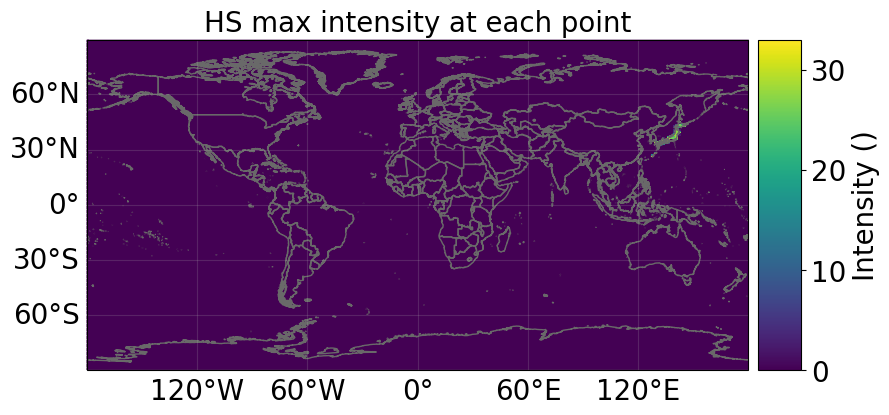

In [8]:
wbgt_haz.plot_intensity(0)

In [9]:
# Some step function 

In [38]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impf_hw = ImpactFunc()
impf_hw.id = 1
impf_hw.haz_type = 'HS'
impf_hw.name = 'Step function heat stress'
impf_hw.intensity_unit = ''
impf_hw.intensity = np.array([0, 0, 31.9, 32, 50])
impf_hw.mdd = np.array([0, 0, 0, 1, 1])
impf_hw.paa = np.ones(impf_hw.intensity.shape)
impf_hw.check() 
impf_set.append(impf_hw)


impf_rf = ImpactFunc()
impf_rf.id = 1
impf_rf.haz_type = 'RF'
impf_rf.name = 'Step function river flood'
impf_rf.intensity_unit = ''
impf_rf.intensity = np.array([0, 0, 0.99, 1, 50])
impf_rf.mdd = np.array([0, 0, 0, 1, 1])
impf_rf.paa = np.ones(impf_rf.intensity.shape)
impf_rf.check() 
impf_set.append(impf_rf)

In [21]:
# we calculate impacts for LitPop population 

In [39]:
litpop_vnm = client.get_litpop(country="JPN", exponents=(0, 1))
litpop_vnm.gdf['impf_HS'] = 1
litpop_vnm.gdf['impf_RF'] = 1


2024-04-30 17:27:08,223 - climada.entity.exposures.base - INFO - Reading /Users/szelie/climada/data/exposures/litpop/LitPop_pop_150arcsec_JPN/v2/LitPop_pop_150arcsec_JPN.hdf5


/Users/szelie/miniconda3/envs/climada_env/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


In [40]:
from climada.util import multi_risk
haz_dict = {'HS': wbgt_haz, 'RF': river_flood}
exp_dict = {'pop':litpop_vnm}
impact_dict = multi_risk.calc_impacts(haz_dict, exp_dict, impf_set, mapping_exp_haz=None)

2024-04-30 17:27:08,491 - climada.entity.exposures.base - INFO - Matching 21999 exposures with 259200 centroids.
2024-04-30 17:27:08,493 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-04-30 17:27:08,676 - climada.engine.impact_calc - INFO - Calculating impact for 65976 assets (>0) and 240 events.
2024-04-30 17:27:08,693 - climada.entity.exposures.base - INFO - Matching 21999 exposures with 21962 centroids.
2024-04-30 17:27:08,694 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-04-30 17:27:08,734 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.
2024-04-30 17:27:08,736 - climada.engine.impact_calc - INFO - Calculating impact for 65976 assets (>0) and 480 events.


# what is the common time definition between our impacts?

In [41]:
multi_risk.find_common_time_definition([impact_dict[('pop', 'RF')].date, impact_dict[('pop', 'HS')].date])

'year'

### --> we need to bring the heat stress hazard to month

In [42]:
impact_dict[('pop', 'HS')] = multi_risk.upscale_dates(impact_dict[('pop', 'HS')], by='year')

In [43]:
def aggregate_impact_by_date(impact, how='sum', exp=None):
    """
    Aggregate events to have lower resolution. Maximum impact per year
    at each exposure point is exposure value if exp is not None.

    Parameters
    ----------
    impact : Impact
        Impact with an impact matrix and events with dates per year
    how : How to aggregate impacts, options are 'sum' or 'max'
    exp : Exposure
        Exposure of Impact to cap the impact value at the value of the exposure

    Raises
    ------
    AttributeError
        If impact matrix is empty.

    Returns
    -------
    impact : Impact
        Impact yearset.

    """
    impact_upscaled_events = copy.deepcopy(impact)
    if how == 'sum':
        mask = [np.ma.make_mask(np.array(impact_upscaled_events.date) == event).astype(int)
                for event in np.unique(impact_upscaled_events.event_name)]
        mask_matrix = sp.sparse.csr_matrix(mask)
        imp_mat = mask_matrix.dot(impact_upscaled_events.imp_mat)

    elif how == 'max':
        imp_mat = sp.sparse.csr_matrix(sp.sparse.vstack(
            [impact_upscaled_events.imp_mat[(np.array(impact_upscaled_dates.date) == date).astype(bool)].max(axis=0)
             for date in np.unique(impact_upscaled_dates.event_name)]))
    else:
        warnings.warn("Unsupported value for 'how' parameter. Only 'sum' and 'max' methods are currently supported.")

    if exp is not None:
        m1 = imp_mat.data
        m2 = np.array(exp.gdf.value[imp_mat.nonzero()[1]])
        imp_mat = sp.sparse.csr_matrix((np.minimum(m1, m2), imp_mat.indices, imp_mat.indptr))

    years = np.unique([datetime.date.fromordinal(int(date)) for date in impact.date])
    frequency = np.ones(imp_mat.shape[0]) / len(np.unique(years))
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, frequency)
    date = np.unique(impact_upscaled_dates.date)
    event_id = np.arange(1, len(at_event) + 1)
    event_name = np.unique(event_id)
    impact_aggr = Impact(
        event_id=event_id,
        event_name=event_name,
        date=date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=impact.coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=frequency,
        tot_value=5,
        unit="USD",
        frequency_unit="1/year"
    )
    return impact_aggr


In [44]:
impact_dict[('pop', 'HS')] = multi_risk.aggregate_events(impact_dict[('pop', 'HS')], by="event_name")

In [45]:
impact_dict[('pop', 'RF')].event_name = ["_".join([event_name.split("_")[0],event_name.split("_")[2], 'rcp85']) for event_name in impact_dict[('pop', 'RF')].event_name]

In [46]:
impact_dict[('pop', 'RF')].event_name

['2010_gfdl-esm2m_rcp85',
 '2011_gfdl-esm2m_rcp85',
 '2012_gfdl-esm2m_rcp85',
 '2013_gfdl-esm2m_rcp85',
 '2014_gfdl-esm2m_rcp85',
 '2015_gfdl-esm2m_rcp85',
 '2016_gfdl-esm2m_rcp85',
 '2017_gfdl-esm2m_rcp85',
 '2018_gfdl-esm2m_rcp85',
 '2019_gfdl-esm2m_rcp85',
 '2020_gfdl-esm2m_rcp85',
 '2021_gfdl-esm2m_rcp85',
 '2022_gfdl-esm2m_rcp85',
 '2023_gfdl-esm2m_rcp85',
 '2024_gfdl-esm2m_rcp85',
 '2025_gfdl-esm2m_rcp85',
 '2026_gfdl-esm2m_rcp85',
 '2027_gfdl-esm2m_rcp85',
 '2028_gfdl-esm2m_rcp85',
 '2029_gfdl-esm2m_rcp85',
 '2010_hadgem2-es_rcp85',
 '2011_hadgem2-es_rcp85',
 '2012_hadgem2-es_rcp85',
 '2013_hadgem2-es_rcp85',
 '2014_hadgem2-es_rcp85',
 '2015_hadgem2-es_rcp85',
 '2016_hadgem2-es_rcp85',
 '2017_hadgem2-es_rcp85',
 '2018_hadgem2-es_rcp85',
 '2019_hadgem2-es_rcp85',
 '2020_hadgem2-es_rcp85',
 '2021_hadgem2-es_rcp85',
 '2022_hadgem2-es_rcp85',
 '2023_hadgem2-es_rcp85',
 '2024_hadgem2-es_rcp85',
 '2025_hadgem2-es_rcp85',
 '2026_hadgem2-es_rcp85',
 '2027_hadgem2-es_rcp85',
 '2028_hadge

In [47]:
# we discard events that are not in common, we only look at one GCM
impact_dict = multi_risk.select_common_events(impact_dict)

2024-04-30 17:27:20,312 - climada.engine.impact - INFO - The eai_exp and aai_agg are computed for the selected subset of events WITHOUT modification of the frequencies.
2024-04-30 17:27:20,317 - climada.engine.impact - INFO - The eai_exp and aai_agg are computed for the selected subset of events WITHOUT modification of the frequencies.


In [24]:
impact_dict[('pop', 'HS')].event_name

array(['2011_gfdl-esm2m_rcp85', '2012_gfdl-esm2m_rcp85',
       '2013_gfdl-esm2m_rcp85', '2014_gfdl-esm2m_rcp85',
       '2015_gfdl-esm2m_rcp85', '2016_gfdl-esm2m_rcp85',
       '2017_gfdl-esm2m_rcp85', '2018_gfdl-esm2m_rcp85',
       '2019_gfdl-esm2m_rcp85', '2020_gfdl-esm2m_rcp85',
       '2021_gfdl-esm2m_rcp85', '2022_gfdl-esm2m_rcp85',
       '2023_gfdl-esm2m_rcp85', '2024_gfdl-esm2m_rcp85',
       '2025_gfdl-esm2m_rcp85', '2026_gfdl-esm2m_rcp85',
       '2027_gfdl-esm2m_rcp85', '2028_gfdl-esm2m_rcp85',
       '2029_gfdl-esm2m_rcp85'], dtype='<U21')

In [48]:
impact_dict[('pop', 'HS')].unit = impact_dict[('pop', 'RF')].unit

In [49]:
import copy
impact_dict_sample = copy.deepcopy(impact_dict)

In [50]:
impact_dict_sample[('pop', 'RF')] = multi_risk.sample_events(impact_dict[('pop', 'RF')], impact_dict[('pop', 'HS')].event_name, 3)

In [51]:
impact_dict_sample[('pop', 'HS')] = multi_risk.sample_events(impact_dict[('pop', 'HS')], impact_dict[('pop', 'HS')].event_name, 3)

In [52]:
impact_dict_sample[('pop', 'HS')].imp_mat

<57x21999 sparse matrix of type '<class 'numpy.float64'>'
	with 4050 stored elements in Compressed Sparse Row format>

In [53]:
impact_aggr = multi_risk.combine_impacts(impact_dict_sample, how='max', by='event_name', exp=None)

<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact ()'>

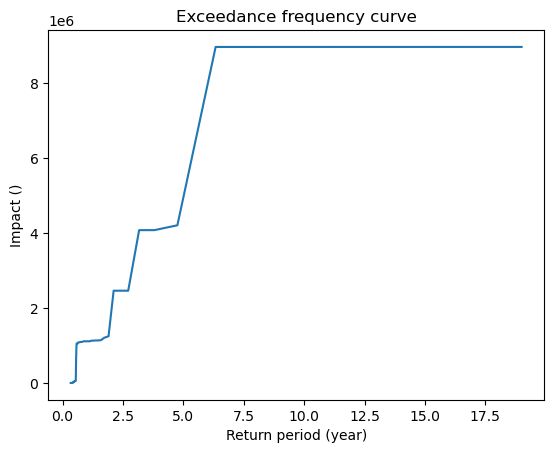

In [54]:
impact_aggr.calc_freq_curve().plot() # obviously need larger event sets to make a meaningful exceedance frequency curve

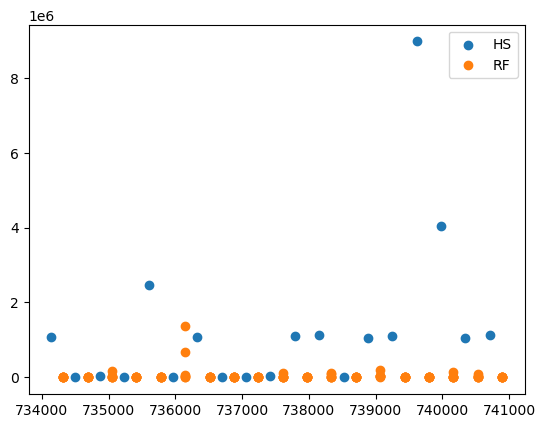

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(impact_dict[('pop', 'HS')].date, impact_dict[('pop', 'HS')].at_event, label="HS")
ax.scatter(impact_dict[('pop', 'RF')].date, impact_dict[('pop', 'RF')].at_event, label="RF")
ax.legend()

In [ ]:
# to do plot maps

In [ ]:
# to do add a third hazard

In [ ]:
# let's get TCs as well 
river_flood = client.get_hazard('tropical_cyclone', properties={'country_iso3alpha':'VNM', 'climate_scenario': 'rcp85', 'year_range':'2010_2030'})